In [2]:
import re
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from Bio import SeqIO, Entrez
import py3Dmol

from dotenv import load_dotenv
env_file = '/home/yuan/bio/bio_omics/src/.env'
load_dotenv(dotenv_path = env_file)

%load_ext autoreload
%autoreload 2

src_dir = os.path.dirname(os.getcwd())
print('src direcotry is ', src_dir)
bioomics_dir = '/home/yuan/bio/bio_omics/src'
for _dir in (src_dir, bioomics_dir):
    if _dir not in sys.path:
        sys.path.append(_dir)
print(sys.path)

src direcotry is  /home/yuan/bio/predict_antibody
['/home/yuan/bio/anaconda3/envs/simulate/lib/python39.zip', '/home/yuan/bio/anaconda3/envs/simulate/lib/python3.9', '/home/yuan/bio/anaconda3/envs/simulate/lib/python3.9/lib-dynload', '', '/home/yuan/bio/anaconda3/envs/simulate/lib/python3.9/site-packages', '/home/yuan/bio/predict_antibody', '/home/yuan/bio/bio_omics/src']


In [82]:
from bioomics import QueryComplex, DistanceAnalyze, DistanceProcess, ProcessPickle
from layout import Layout
from plot_predict import PlotPredict
from plot_binding import PlotBinding
from load_data import LoadData

In [60]:
ab_combo2 = QueryComplex(True).ab_combo2()
ab_combo2.head(1)

,pdb_id,combo_id,chain_combo,ab_chain_no
0,1NSN,1NSN_0_H-L,H-L,L-H


### distance cutoff

In [112]:
pfile = '/home/yuan/output/pdb/collect/distance/count_contacts_combo2_distance.pkl'
data = ProcessPickle(pfile).load_pickle()

num_contacts = {}
for cutoff in data:
    sub = pd.DataFrame(data[cutoff])
    num_contacts[cutoff] = pd.merge(sub, ab_combo2, how='inner', on='combo_id')
    print(cutoff, num_contacts[cutoff].shape)

1 (109, 9)
3 (39658, 9)
5 (49848, 9)
10 (58862, 9)
15 (67512, 9)
20 (77211, 9)
30 (94416, 9)
50 (116979, 9)


<Axes: xlabel='num_ca', ylabel='Count'>

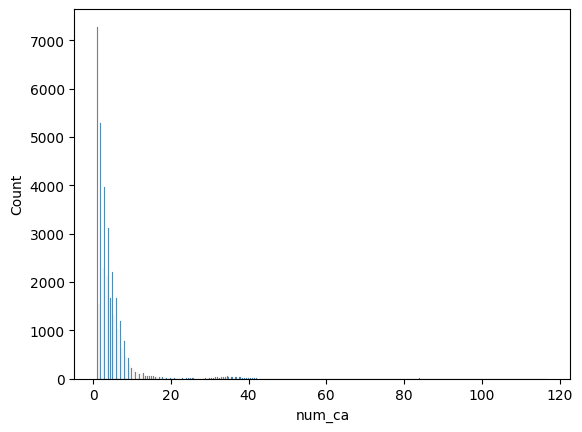

In [113]:
df1 = num_contacts[3]
sns.histplot(df1, x='num_ca')

## binding energy

In [198]:
query = """
    select * from combo2_contacts
    where pdb_id in (
        select pdb_id from view_antibody    
    );
"""
cdf = QueryComplex(True).list_data(query, True)
# keep antibody only
cdf = pd.merge(cdf, ab_combo2, how='inner', on='combo_id')
cdf['log-kd'] = cdf['dissociation_constant'].map(lambda x: np.log(x))
print(cdf.shape)
print(cdf.iloc[0].to_dict())

(137710, 9)
{'pdb_id_x': '3IJH', 'combo_id': '3IJH_0_A-B', 'binding_affinity': -14.6, 'dissociation_constant': 1.9e-11, 'relative_prodigy': 'combo2_contacts/3I/3IJH/3IJH_0_A-B.txt', 'pdb_id_y': '3IJH', 'chain_combo': 'A-B', 'ab_chain_no': 'B-A', 'log-kd': -24.68658213676211}


In [189]:
# not binding
cdf0 = cdf[cdf['binding_affinity'].isna()]
print('no binding:', len(cdf0))

# bidning
cdf1 = cdf[cdf['binding_affinity'].notna()]
print('binding:', len(cdf1))

no binding: 85523
binding: 48927


In [190]:
# compare min-distance with prodigy estimates
non_combo = set(cdf0['combo_id'])
for cutoff in num_contacts:
    sub = num_contacts[cutoff]
    inter = non_combo.intersection(sub['combo_id'])
    print(cutoff, len(sub), len(inter))

1 109 2
3 39658 19
5 49848 142
10 58862 8114
15 67512 16506
20 77211 25915
30 94416 42548
50 116979 64433


figure size: 8.5 x 6 cm


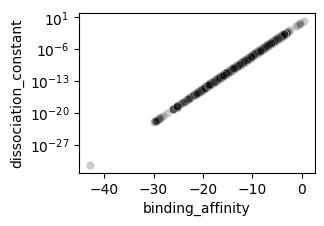

In [191]:
args = {'width_level':1, 'height':6}
fig, ax = Layout(args).one()

sns.scatterplot(cdf1, x='binding_affinity', y='dissociation_constant', ax=ax, color='black', alpha=.2)
ax.set_yscale('log')

figure size: 8.5 x 6 cm


Text(0, 0.5, 'Number of dimers')

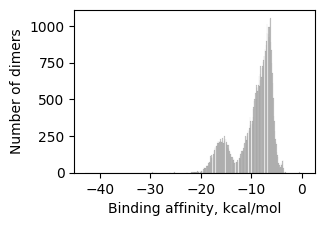

In [192]:
args = {'width_level':1, 'height':6}
fig, ax = Layout(args).one()

sns.histplot(cdf1, x='binding_affinity', ax=ax, bins=500, color='black', alpha=.2)
ax.set_xlabel('Binding affinity, kcal/mol')
ax.set_ylabel('Number of dimers')

figure size: 8.5 x 6 cm


Text(0, 0.5, 'Number of dimers')

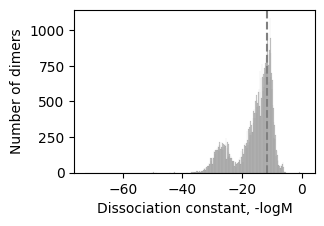

In [193]:
args = {'width_level':1, 'height':6}
fig, ax = Layout(args).one()

sns.histplot(cdf1, x='log-kd', ax=ax, bins=500, color='black', alpha=.2)
ax.axvline(np.log(1e-5), linestyle='--', color='grey')
ax.set_xlabel('Dissociation constant, -logM')
ax.set_ylabel('Number of dimers')

In [323]:
abag = QueryComplex(True).abag_combo2()
abag = abag.drop('pdb_id', axis=1)
print(len(abag))
abag.head(1)

77097


,combo_id,chain_combo,ab_chain_no
0,1NSN_0_H-S,H-S,H


In [324]:
df = ddf.merge(abag, how='inner', on='combo_id')
print(len(df))
df.head(1)

77072


,pdb_id,combo_id,relative_pkl,ranked_dist1,ranked_dist2,1th,5th,10th,mean5th,mean10th,chain_combo,ab_chain_no
0,9IJS,9IJS_0_A-H,combo2_distance/9I/9IJS/9IJS_0_A-H.pkl,"5,7,8,9,12,12,17,22,23,23,24,25,25,25,25,25,25...","5,7,8,8,8,8,9,9,10,10,10,11,11,12,12,12,12,12,...",5.0,8.0,10.0,7.0,8.0,A-H,H


### distance threshold

In [439]:
pfile = '/home/yuan/output/pdb/collect/distance/distance_abag_combo2_distance.pkl'
df = LoadData.abag_dist_stat(pfile)
df.head(1)

number of abag dimer: 77326


,pdb_id,combo_id,chain_combo,ab_chain_no,1th,2th,3th,4th,5th,10th,mean5th,mean10th
0,8G70,8G70_0_D-F,D-F,F,5.484213,3.137771,8.049318,10.151517,13.185985,23.386263,3.159263,3.246582


In [650]:
from sklearn.metrics import roc_curve, auc

def cal_droc(df, col):
    pool = []
    g = df.groupby(['pdb_id', 'ab_chain_no'])
    for (pdb_id, ab_chain_no), sub0 in g:
        sub = sub0[['combo_id', 'ab_chain_no', col]].reset_index()
        sub = sub.sort_values(col)
        if len(sub) > 1:
            sub['y'] = [1,] + [0,] * (len(sub)-1)
        else:
            sub['y'] = [1,] * len(sub)
        pool.append(sub)
    droc = pd.concat(pool)
    droc = droc.dropna()
    print(col, len(droc))
    return dr

In [686]:
data = {}
for col in ('1th','2th','3th','4th','5th','10th','mean5th','mean10th'):
    data[col] = cal_droc(df, col)

1th 77326
2th 77326
3th 77326
4th 77326
5th 77326
10th 77326
mean5th 77326
mean10th 77326


figure size: 17.4 x 6 cm


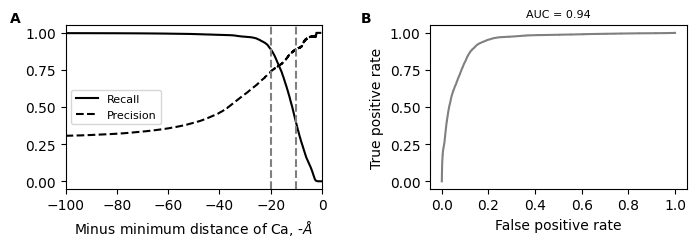

In [714]:
args = {'width_level':3, 'height':6}
label_x = (-40, -50)
label_y = 10
fig, axes = Layout(args).row(label_x, label_y)

col = '1th'
PlotBinding(data).precision_recall(axes[0], col)
PlotBinding(data).roc(axes[1], col)

fig.savefig(f'../figures/abag_distance_threshold_{col}.tif', dpi=300, bbox_inches='tight', pad_inches=.05)

figure size: 17.4 x 6 cm


<Axes: title={'center': 'AUC = 0.94'}, xlabel='False positive rate', ylabel='True positive rate'>

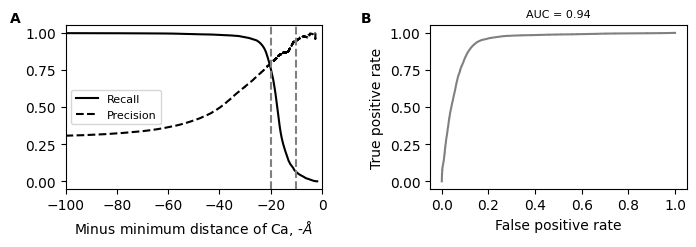

In [712]:
args = {'width_level':3, 'height':6}
label_x = (-40, -50)
label_y = 10
fig, axes = Layout(args).row(label_x, label_y)

col = '5th'
PlotBinding(data).precision_recall(axes[0], col)
PlotBinding(data).roc(axes[1], col)

figure size: 17.4 x 6 cm


<Axes: title={'center': 'AUC = 0.91'}, xlabel='False positive rate', ylabel='True positive rate'>

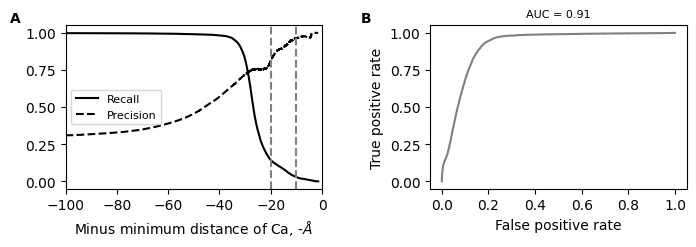

In [713]:
args = {'width_level':3, 'height':6}
label_x = (-40, -50)
label_y = 10
fig, axes = Layout(args).row(label_x, label_y)

col = '10th'
PlotBinding(data).precision_recall(axes[0], col)
PlotBinding(data).roc(axes[1], col)

### data from combo2_distance

In [300]:
query = """
    select * from combo2_distance
    where pdb_id in (
        select pdb_id from view_antibody    
    );
"""
ddf = QueryComplex(True).list_data(query, True)
ddf = ddf.dropna()
# keep antibody only
ddf = ddf.merge(ab_combo2, how='inner', on='combo_id')


print(ddf.shape)
ddf.head(1)

(137674, 13)


,pdb_id_x,combo_id,relative_pkl,ranked_dist1,ranked_dist2,pdb_id_y,chain_combo,ab_chain_no,1th,5th,10th,mean5th,mean10th
0,3IJH,3IJH_0_A-B,combo2_distance/3I/3IJH/3IJH_0_A-B.pkl,"2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,4,4,...","2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,4,4,4,4,4,...",3IJH,A-B,B-A,2.0,3.0,3.0,2.0,2.0


In [307]:
cddf = pd.merge(cdf, ddf, how='inner', on='combo_id')

# not binding
cddf0 = cddf[cddf['binding_affinity'].isna()]
print('no binding:', len(cddf0))

# bidning
cddf1 = cddf[cddf['binding_affinity'].notna()]
print('binding:', len(cddf1))

no binding: 87615
binding: 50059


figure size: 17.4 x 8 cm


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


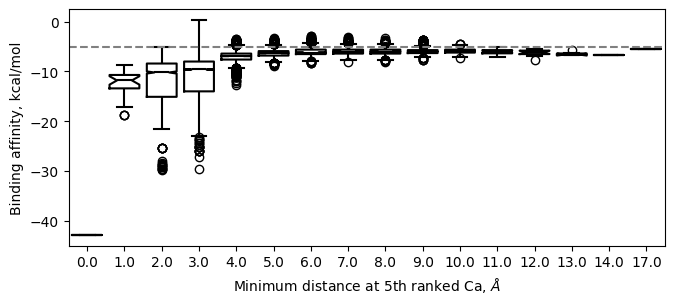

In [302]:
args = {'width_level':3, 'height':8}
fig, ax = Layout(args).one()

col = '5th'
cddf2 = cddf1[cddf1[col]<=30]
sns.boxplot(cddf2, x=col, y='binding_affinity', ax=ax, notch=True, fill=False, color='black')
ax.set_xlabel(f"Minimum distance at {col} ranked Ca, $\AA$")
ax.set_ylabel('Binding affinity, kcal/mol')
ax.axhline(-5, color='grey', linestyle='--')

figure size: 17.4 x 8 cm


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


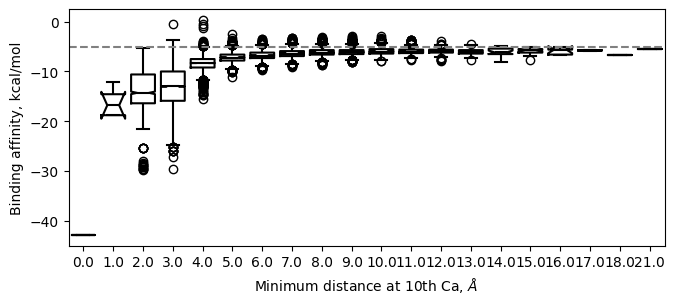

In [303]:
args = {'width_level':3, 'height':8}
fig, ax = Layout(args).one()

col = '10th'
cddf2 = cddf1[cddf1[col]<=30]
sns.boxplot(cddf2, x=col, y='binding_affinity', ax=ax, notch=True, fill=False, color='black')
ax.set_xlabel(f"Minimum distance at {col} Ca, $\AA$")
ax.set_ylabel('Binding affinity, kcal/mol')
ax.axhline(-5, color='grey', linestyle='--')

figure size: 8.5 x 6 cm


Text(0, 0.5, 'Minimum distance of Ca, $\\AA$')

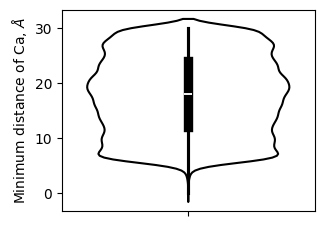

In [309]:
args = {'width_level':1, 'height':6}
fig, ax = Layout(args).one()

col = '1th'
cddf3 = cddf0[cddf0[col]<=30]
sns.violinplot(cddf3, y=col, ax=ax, fill=False, color='black')
ax.set_ylabel("Minimum distance of Ca, $\AA$")

figure size: 8.5 x 6 cm


Text(0, 0.5, 'Minimum distance of Ca, $\\AA$')

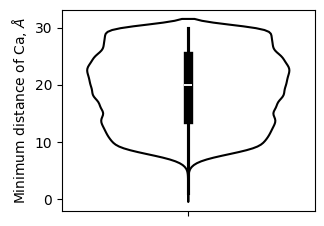

In [312]:
args = {'width_level':1, 'height':6}
fig, ax = Layout(args).one()

col = '5th'
cddf3 = cddf0[cddf0[col]<=30]
sns.violinplot(cddf3, y=col, ax=ax, fill=False, color='black')
ax.set_ylabel("Minimum distance of Ca, $\AA$")

In [4]:
# retrieve interface sequences
table_name = 'combo2_distance'
cutoff = 10
span =5
file_name = f"{table_name}_cutoff{cutoff}_span{span}"
infile = f'/home/yuan/output/pdb/collect/distance/{file_name}.csv'
motifs = pd.read_csv(infile)

print(len(motifs))
motifs.head(1)

463459


,seq,pair_aa,sig_res,start,end,dist_cutoff,max_span,chain_no,pair_chain_no,pdb_id,combo_id
0,QIVLTQSPAI,KGKLQGGIII,7,0,9,10.0,5,C,D,3J2Y,3J2Y_0_C-D


In [10]:
df = pd.merge(motifs, cdf, how='left', on='combo_id')
df.head(1)

,seq,pair_aa,sig_res,start,end,dist_cutoff,max_span,chain_no,pair_chain_no,pdb_id_x,combo_id,pdb_id_y,binding_affinity,dissociation_constant,relative_prodigy
0,QIVLTQSPAI,KGKLQGGIII,7,0,9,10.0,5,C,D,3J2Y,3J2Y_0_C-D,3J2Y,-16.9,4.200000e-13,combo2_contacts/3J/3J2Y/3J2Y_0_C-D.txt


In [58]:
ab_comb2.head(10)

,pdb_id,combo_id,chain_combo,ab_chain_no
0,1NSN,1NSN_0_H-L,H-L,L-H
1,1NSN,1NSN_0_H-S,H-S,H
2,1NSN,1NSN_0_L-S,L-S,L
3,1R3I,1R3I_0_C-H,C-H,H
4,1R3I,1R3I_0_C-L,C-L,L
5,1R3I,1R3I_0_H-L,H-L,L-H
6,1R3J,1R3J_0_A-B,A-B,B-A
7,1R3J,1R3J_0_A-C,A-C,A
8,1R3J,1R3J_0_B-C,B-C,B
9,1R3K,1R3K_0_A-B,A-B,B-A
